##What we need to do
* Figure out and implement a matrix representation of inputs, weight and outputs which allows for efficient matrix operations
* Make a representation of a MLP (that is weights, input dimension, layers, layer dimensions(, activation functions) and output dimension)
* Make the backprop algorithm applicable to this representation
* Print functions (Printing a 2d function approximation in 3d space, A normal plot for error over epoch etc, )
* Generate data
* Split data into subsets
* Evaluate trained network on test/validation sets
* (Function which approximates and prints where the classification boundary is, i.e. where the network output is 0)
* Familirize ourselves and use a MLP framework to answer part 2 questions
* (If we implement the backprop algo and MLP class correctly the encoder should be trivial (except for the evaluation of the hidden layer which requires some extra work))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
"""
General notes:
Should we try to implement early stopping? Manually or with validation set?

Notation/data structure notes:
We use -1,1 for binary classification
N: number of samples
M_i: number of nodes in hidden layer i
S: number of hidden layers
Input matrix on the form (inDim, N)
Weight matrix saved as a list (S+1 entries) of matrixes (M_(i+1),M_i + 1) (Add a one to account for bias in every hidden level)
  for the first layer the matrix will have dimensions (M_1,inDim+1)
  for the last layer the matrix will have dimensions (outDim, M_i + 1)
  (This is kinda overkill since we only use two layered perceptrons)

Implementation notes:
We could implement the the activation functions and their derivatives as associated functions in the MLP class
In the example they add a bias term even in the hidden layer. Is this supposed to be done for every hidden layer or just the first?
  As far as I can tell they add a bias for every hidden layer instead of just the first. I don't understand why?
    Is it that every layer can be seen as as separating the input into a new problem which needs its own bias to separate?
"""
dummy=0

##Part I

####General Functions

In [ ]:
def standard_activation_function(x, derivative=False):
  if not derivative:
    return 2/(1 + math.e**(-x))-1
  else: #This is an inefficient solution since we could save the value from the forward pass and reuse it. But since we only use one layer it does not make a large difference
    temp=2/(1 + math.e**(-x))-1
    return (1+temp)*(1-temp)*0.5

In [ ]:
class NeuralNetwork:

    def __init__(self, X, y, n_hidden_neurons, eta, alpha = 0, activation_function = standard_activation_function):

        self.X_bias = np.r_['0,2', X, np.ones(X.shape[1])]  #Input with added bias (features+1, samples)
        self.y = y  #Targets

        self.n_samples = X.shape[1]
        self.n_features = X.shape[0] + 1
        self.n_output_features = 1 if y.ndim==1 else y.shape[0]
        self.n_hidden_neurons = n_hidden_neurons

        self.epochs_trained = 0
        self.eta = eta
        self.alpha = alpha
        self.activation_function = activation_function

        self.create_biases_and_weights()


    def create_biases_and_weights(self):

        # create weights from input to hidden layer
        self.hidden_weights = np.random.randn(self.n_hidden_neurons, self.n_features)

        #create weights from hidden to output
        self.output_weights = np.random.randn(self.n_output_features, self.n_hidden_neurons+1)


    def feed_forward(self):
        # feed-forward for training

        # from input to hidden layer
        self.h_in = self.hidden_weights @ self.X_bias
        self.h_out = self.activation_function(self.h_in)
        self.h_out=np.r_['0,2', self.h_out, np.ones(self.h_out.shape[1])]

        #from hidden to output layer
        self.o_in = self.output_weights @ self.h_out
        self.o_out = self.activation_function(self.o_in)


    def feed_forward_out(self, X):
        # feed-forward for output

        X = np.r_['0,2', X, np.ones(X.shape[1])]

        # from input to hidden layer
        h_in = self.hidden_weights @ X
        h_out = self.activation_function(h_in)
        h_out=np.r_['0,2', h_out, np.ones(h_out.shape[1])]

        #from hidden to output layer
        o_in = self.output_weights @ h_out
        o_out = self.activation_function(o_in)

        return o_out

    def backpropagation(self):

        #calculate the output error
        self.error_output = self.o_out - self.y

        #iterate the error back (output)
        self.delta_o = self.error_output * self.activation_function(self.o_in, derivative=True)
        #self.delta_o = self.error_output * self.activation_function(self.o_out, derivative=True)
        self.grad_o = self.delta_o @ self.h_out.T

        #iterate the error back (hidden)
        self.delta_h = (self.output_weights.T @ self.delta_o)[:self.n_hidden_neurons] * self.activation_function(self.h_in, derivative=True)
        #self.delta_h = (self.output_weights.T @ self.delta_o) * self.activation_function(self.h_out, derivative=True)
        #self.delta_h = self.delta_h[:self.n_hidden_neurons, :]
        self.grad_h = self.delta_h @ self.X_bias.T
        #delta_h = delta_h(0:self.n_hidden_neurons, :)

        # weight update with momentum
        # if alpha = 0: self.output_weights -= self.eta * self.grad_o
        self.output_weights += self.eta * ((self.alpha * self.output_weights) - ((1 - self.alpha) * self.grad_o))
        self.hidden_weights += self.eta * ((self.alpha * self.hidden_weights) - (( 1- self.alpha) * self.grad_h))

    def predict(self, X):
        values = self.feed_forward_out(X)
        return values

    def train(self, epochs):
        for i in range(epochs):
            self.feed_forward()
            self.backpropagation()
            self.epochs_trained+=1


In [ ]:
#gives the Mean Square Error of target and values
def MSE(targets, values):
  return np.mean((targets-values)**2)

In [ ]:
#accuracy score
def accuracy_score(targets, values):
    return np.mean(targets == values)

In [ ]:
#Shuffles input matrix (inDim,N) and corresponding target vector (N)
def shuffle_data(inputmat, targetvec):
    N=inputmat.shape[1]
    index=np.random.permutation(N)
    return inputmat[:,index], targetvec[index]
#shuffleData(np.arange(10).reshape((2,5)),np.arange(5)) #Sanity test

In [ ]:
def merge_data(class_A, class_B, target_A, target_B):
    training_data = np.concatenate((class_A, class_B), axis = 1)
    targets = np.concatenate((target_A, target_B))
    return training_data, targets

####Print functions

In [ ]:
#Function which takes in an array of point (2,n) and corresponding labels (n) and then prints a scatter plot for the data
def printBinaryData(data, labels, title, y_lim_sub = -0.75, y_lim_sup = 0.95, xlab = "x1", ylab = "x2"):
    plt.figure(figsize=(7,7))
    scatter = plt.scatter(data[0,:], data[1,:], c=labels)
    plt.legend(*scatter.legend_elements())
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.ylim(y_lim_sub, y_lim_sup)

#Function which draws a crude approximation of the decision boundary of a binary MLP with one output node
def printDecisionBoundary(NN, resolution=100, boundaryWidth=0.05, color="r"):
  N=resolution**2
  x1min, x1max=min(NN.X_bias[0]), max(NN.X_bias[0])
  x1size=x1max-x1min
  x2min, x2max=min(NN.X_bias[0]), max(NN.X_bias[0])
  x2size=x2max-x1min

  #Create test points
  testPoints=np.zeros((2,N))
  for i in range(resolution):
    testPoints[0,(i*resolution):((i+1)*resolution)]=np.linspace(x1min,x1max,resolution)
    testPoints[1,(i*resolution):((i+1)*resolution)]=x2min+i*x2size/resolution

  #Find points which almost evaluate to zero
  output=NN.feed_forward_out(testPoints)
  pointsAndOutput=np.concatenate((testPoints,output),axis=0)
  boundaryPoints=pointsAndOutput[:2,abs(pointsAndOutput[2]) < boundaryWidth]

  plt.scatter(boundaryPoints[0],boundaryPoints[1], c=color)

#Plotts from a coordinate mesh of x, y with corresponding result z (All three as matrixes)
def plot3D(x,y,z, title="test", zlim=(-0.7, 0.7), c="b"):
  ax = plt.figure(figsize=(10,10)).add_subplot(111, projection='3d')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_zlim(zlim)
  ax.set_title(title)

  #ax.plot_surface(x,y,z, color=c)
  ax.plot_wireframe(x,y,z, color=c)

#Assumes points is a flattened square mesh
def print3DFromNetwork(points, nn, titel="test", zlim=(-0.7, 0.7), c="b"):
  N=points.shape[1]
  n=round(np.sqrt(N))
  assert(n*n==N)
  X=points[0,:].reshape((n,n))
  Y=points[1,:].reshape((n,n))
  Z=nn.predict(points).reshape((n,n))

  plot3D(X,Y,Z,titel,zlim, c)

In [ ]:
#Code for testing printing decision boundary
n = 100 #Number of data points per class
mA = [ 1.0, 0.1]
mB = [ 0.0, -0.1]
sigmaA = 0.2
sigmaB = 0.3

np.random.seed(29)

classA = np.zeros((2, n))
classB = np.zeros((2, n))
labels = np.zeros(2*n)

classA[0,:round(n/2)] = sigmaA * np.random.randn(1,round(n/2)) - mA[0]
classA[0,round(n/2):] = sigmaA * np.random.randn(1,round(n/2)) + mA[0]
classA[1,:] = sigmaA * np.random.randn(1,n) + mA[1]
labels[:n] = 1

classB[0,:round(n/2)] = sigmaB * np.random.randn(1,round(n/2)) - mB[0]
classB[0,round(n/2):] = sigmaB * np.random.randn(1,round(n/2)) + mB[0]
classB[1,:] = sigmaB * np.random.randn(1,n) + mB[1]
labels[n:] = -1

data=np.concatenate((classA,classB),axis=1)

# nn = NeuralNetwork(X = data, y = labels, eta=0.001, alpha = 0.9,  n_hidden_neurons=20)
# nn.train(500)

# #printBinaryData(data, nn.predict(data), "temp")
# printBinaryData(data, labels, "temp")
# printDecisionBoundary(nn, boundaryWidth=0.02)

####Functions for splitting data into subsets

In [ ]:
#Function for splitting dataset (Assumes shuffled data set)
# split_type="percentage": splits the first p % of the data
# split_type="splitA": removes p % of class A  (assumes class A and B binary, one output node with labels 1, -1)
# split_type="splitB": removes p % of class B  (assumes class A and B binary, one output node with labels 1, -1)
# split_type="splitEven": removes p % from both classes (assumes class A and B binary, one output node with labels 1, -1)
# split_type="special": cuts out 20% of class a where x1 less than zero and 80% where x1 greater than zero

def splitData(data, targets, p=50, split_type="percentage"):
    p=p/100
    targetDim = targets.ndim
    N = len(targets) if targetDim==1 else targets.shape[1]
    #variables for if there are two classes
    nA, nB = 0 ,0
    dataA, dataB = 0, 0

    if split_type=="splitEven" or split_type=="splitA" or split_type=="splitB" or split_type=="special": #Allows the data to be unevenly split and/or already shuffled before being sent into the function.
      targetsWithIndex=np.concatenate((targets.reshape((1,N)), np.arange(N).reshape((1,N))), axis=0)
      indexesA=targetsWithIndex[1,targetsWithIndex[0]==1].astype(int)
      indexesB=targetsWithIndex[1,targetsWithIndex[0]==-1].astype(int)
      nA=len(indexesA)
      nB=len(indexesB)
      dataA=data[:,indexesA]
      dataB=data[:,indexesB]

    splitData, splitTargets, residualData, residualTargets = 0,0,0,0

    if split_type=="percentage":
      splitData=data[:,:round(p*N)]
      splitTargets=targets[:round(p*N)] if targets.ndim==1 else targets[:,:round(p*N)]  #Allows for output of more than 1 node
      residualData=data[:,round(p*N):]
      residualTargets=targets[round(p*N):] if targets.ndim==1 else targets[:,round(p*N):]

    elif split_type=="splitEven":
      splitDataA=dataA[:,:round((1-p)*nA)]
      splitDataB=dataB[:,:round((1-p)*nB)]
      splitData=np.concatenate((splitDataA,splitDataB), axis=1)

      splitTargetsA=np.ones(round((1-p)*nA))
      splitTargetsB=(-np.ones(round((1-p)*nB)))
      splitTargets=np.concatenate((splitTargetsA, splitTargetsB))

      splitData, splitTargets = shuffle_data(splitData, splitTargets)

      residualDataA=dataA[:,round((1-p)*nA):]
      residualDataB=dataB[:,round((1-p)*nB):]
      residualData=np.concatenate((residualDataA,residualDataB), axis=1)

      residualTargetsA=np.ones(round(p*nA))
      residualTargetsB=(-np.ones(round(p*nA)))
      residualTargets=np.concatenate((residualTargetsA, residualTargetsB))

      residualData, residualTargets = shuffle_data(residualData, residualTargets)

    elif split_type=="splitA" or split_type=="splitB":
      if split_type=="splitA":
        splitDataA=dataA[:,:round((1-p)*nA)]
        splitDataB=dataB

        residualDataA=dataA[:,round((1-p)*nA):]
        residualDataB=np.ndarray((2,0))

        splitTargetsA=np.ones(round((1-p)*nA))
        splitTargetsB=(-np.ones(nB))

        residualTargetsA=np.ones(round(p*nA))
        residualTargetsB=(-np.ones(0))
      else:
        splitDataA=dataA
        splitDataB=dataB[:,:round((1-p)*nB)]

        residualDataA=np.ndarray((2,0))
        residualDataB=dataB[:,round((1-p)*nB):]

        splitTargetsA=np.ones(nA)
        splitTargetsB=(-np.ones(round((1-p)*nB)))

        residualTargetsA=np.ones(0)
        residualTargetsB=(-np.ones(round(p*nB)))

      splitData=np.concatenate((splitDataA,splitDataB), axis=1)
      splitTargets=np.concatenate((splitTargetsA, splitTargetsB))
      splitData, splitTargets = shuffle_data(splitData, splitTargets)

      residualData=np.concatenate((residualDataA,residualDataB), axis=1)
      residualTargets=np.concatenate((residualTargetsA, residualTargetsB))
      residualData, residualTargets = shuffle_data(residualData, residualTargets)

    elif split_type=="special":
      dataAltZero = dataA[:,dataA[0] < 0]
      dataAgtZero = dataA[:,dataA[0] >= 0]
      nAltZero=dataAltZero.shape[1]
      nAgtZero=dataAgtZero.shape[1]

      splitDataAltZero=dataAltZero[:,:round(nAltZero*0.8)]
      splitDataAgtZero=dataAgtZero[:,:round(nAgtZero*0.2)]
      splitDataA=np.concatenate((splitDataAltZero,splitDataAgtZero), axis=1)

      splitData=np.concatenate((splitDataA,dataB),axis=1)

      splitTargetsA=np.ones(splitDataA.shape[1])
      splitTargetsB=(-np.ones(nB))

      splitTargets=np.concatenate((splitTargetsA, splitTargetsB))

      splitData, splitTargets = shuffle_data(splitData, splitTargets)

      residualDataAltZero=dataAltZero[:,round(nAltZero*0.8):]
      residualDataAgtZero=dataAgtZero[:,round(nAgtZero*0.2):]
      residualDataA=np.concatenate((splitDataAltZero,splitDataAgtZero), axis=1)

      residualData=residualDataA

      residualTargets=np.ones(residualData.shape[1])

      residualData, residualTargets = shuffle_data(residualData, residualTargets)


    else:
      print("Error!!!!!!!!!!!!!", split_type, "is not an acceptable split type")

    return splitData, splitTargets, residualData, residualTargets

# Classification and regression with a two-layer perceptron

## Classification of linearly non-separable data

Generate Data

<Figure size 504x432 with 0 Axes>

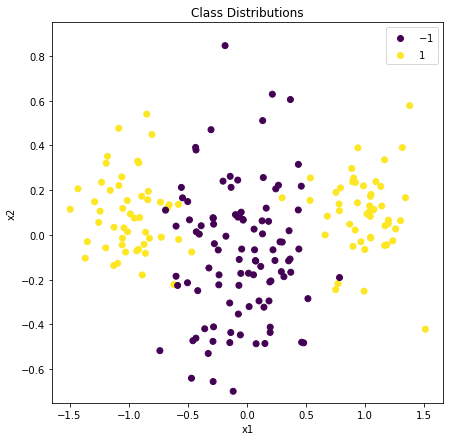

In [ ]:
#Generate data according to 3.1.1
#Generate data and labels (use a known seed)

n = 100 #Number of data points per class
mA = [ 1.0, 0.1]
mB = [ 0.0, -0.1]
sigmaA = 0.2
sigmaB = 0.3

np.random.seed(29)

classA = np.zeros((2, n))
classB = np.zeros((2, n))
labels = np.zeros(2*n)

classA[0,:round(n/2)] = sigmaA * np.random.randn(1,round(n/2)) - mA[0]
classA[0,round(n/2):] = sigmaA * np.random.randn(1,round(n/2)) + mA[0]
classA[1,:] = sigmaA * np.random.randn(1,n) + mA[1]
labels[:n] = 1

classB[0,:round(n/2)] = sigmaB * np.random.randn(1,round(n/2)) - mB[0]
classB[0,round(n/2):] = sigmaB * np.random.randn(1,round(n/2)) + mB[0]
classB[1,:] = sigmaB * np.random.randn(1,n) + mB[1]
labels[n:] = -1

data=np.concatenate((classA,classB),axis=1)
data, labels = shuffle_data(data, labels)

plt.figure(figsize=(7,6))
printBinaryData(data, labels, title = "Class Distributions")

Training Error as number of Hidden Nodes varies

Mean Square Error: [0.989 0.402 0.258 0.249 1.068 1.081 0.197 1.085 1.06 ] 
 Accuracy: [0.61  0.945 0.95  0.955 0.73  0.725 0.955 0.72  0.735]


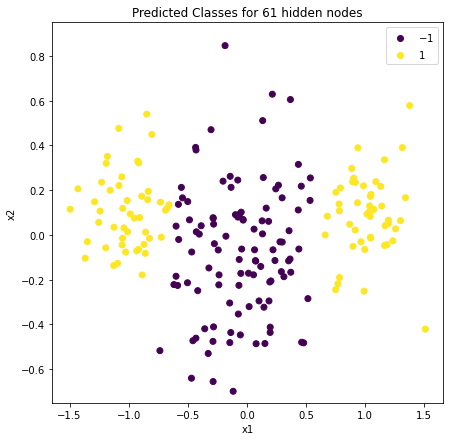

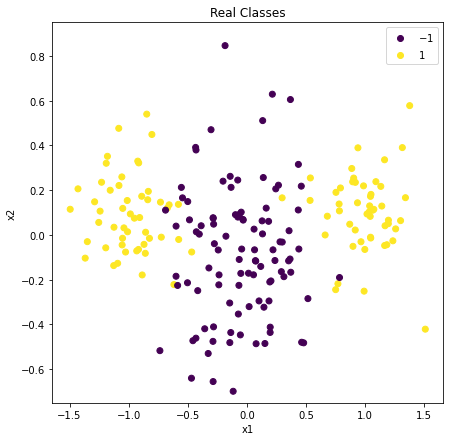

In [ ]:
hidden_nodes = np.arange(1,90,10)
mse = np.zeros(len(hidden_nodes))
accuracy = np.zeros(len(hidden_nodes))

np.random.seed(161)
for i,h in enumerate(hidden_nodes):
    nn = NeuralNetwork(X = data, y = labels, eta=0.001, alpha = 0.1,  n_hidden_neurons=h)
    nn.train(300)

    y_predict = nn.predict(data)
    t = np.array([-1 if i < 0 else 1 for i in y_predict.T]) #Hack job

    mse[i] = MSE(labels, y_predict)
    accuracy[i] = accuracy_score(labels, t)

    #Visualizes the decision
    if i==6:
        printBinaryData(data, t, "Predicted Classes for "+str(h)+" hidden nodes")
        printBinaryData(data, labels, "Real Classes")

print("Mean Square Error:", np.round(mse, 3), "\n", "Accuracy:", np.round(accuracy, 3))

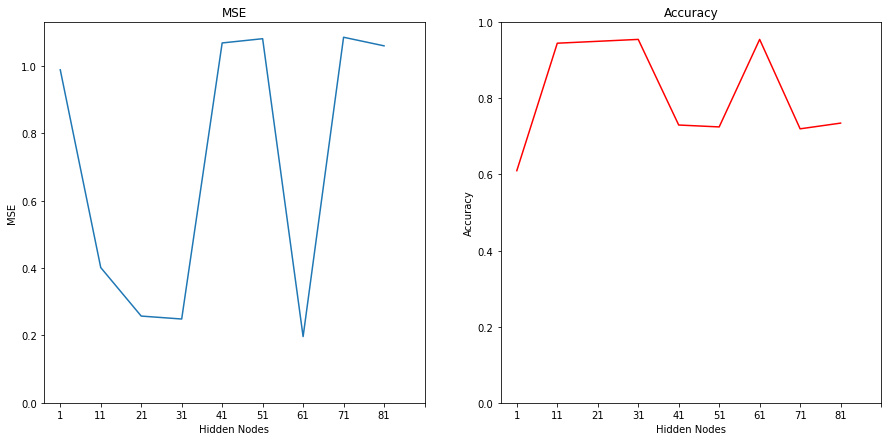

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.plot(mse)
plt.title("MSE")
plt.ylabel("MSE")
plt.ylim(0)
plt.xlabel("Hidden Nodes")
plt.xticks(np.arange(10), hidden_nodes)
plt.subplot(122)
plt.plot(accuracy, c = "red")
# plt.plot(h=1)
plt.title("Accuracy")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.xlabel("Hidden Nodes")
plt.xticks(np.arange(10), hidden_nodes)
plt.show();

Few hidden nodes produce low accuracy and high errors, as do many hidden nodes. However, if the seed of the neural network is changed, the results could differ very much. Having only 150 training points, the network is more susceptible to randomization.

Train-test split

In [ ]:
train_data25, train_targets25, test_data25, test_targets25 = splitData(data, labels, 25, "splitEven")
#test_data25, test_targets25, train_data25, train_targets25 = splitData(data, labels, 25, "splitEven")  #Reverse train with test, shows how the data is distributed such that the test set is way easier to classify (which is why or test error is lower)
train_data50, train_targets50, test_data50, test_targets50  = splitData(data, labels, 50, "splitA")
train_data_s, train_targets_s, test_data_s, test_targets_s  = splitData(data, labels, 50, "special")

/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


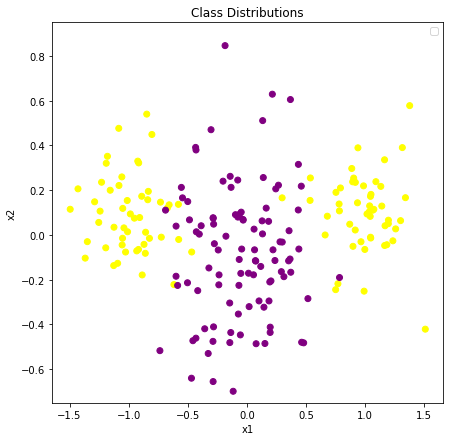

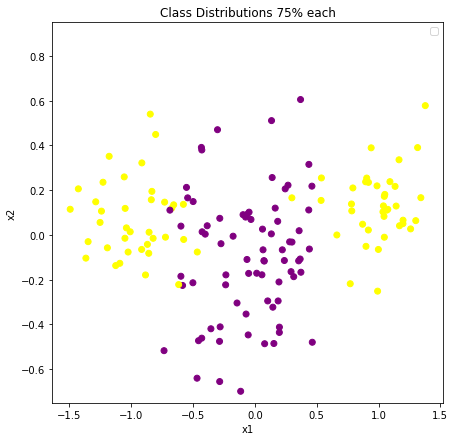

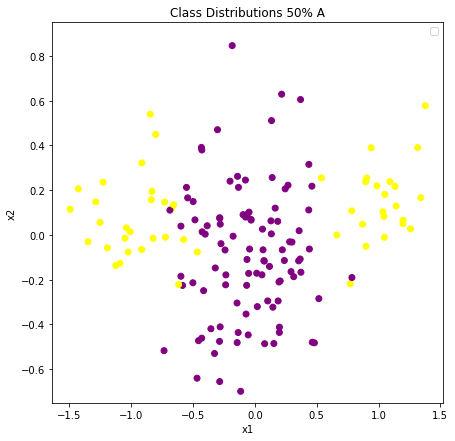

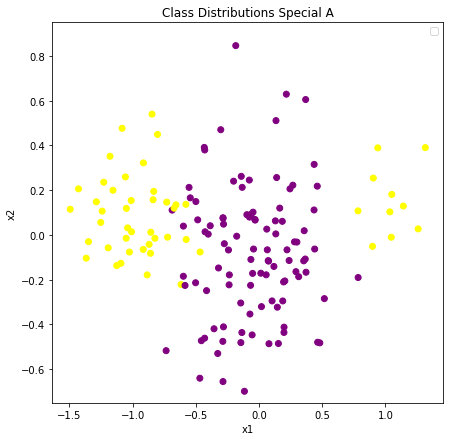

In [ ]:
printBinaryData(data, labels, title = "Class Distributions" )
printBinaryData(train_data25, train_targets25, title = "Class Distributions 75% each")
printBinaryData(train_data50, train_targets50, title = "Class Distributions 50% A")
printBinaryData(train_data_s, train_targets_s, title = "Class Distributions Special A")

Test: random 25% from each class

In [ ]:
epochs = 300

hidden_nodes = np.arange(1,100,10)

mse_train = np.zeros((len(hidden_nodes), epochs))
accuracy_train = np.zeros((len(hidden_nodes), epochs))

mse_test = np.zeros((len(hidden_nodes), epochs))
accuracy_test = np.zeros((len(hidden_nodes), epochs))

np.random.seed(17)
for i,h in enumerate(hidden_nodes):
    nn = NeuralNetwork(X = train_data25, y = train_targets25, eta=0.001, alpha = 0.25,  n_hidden_neurons=h)
    for e in range(epochs):
        nn.train(1)

        y_predict_test = nn.predict(test_data25)
        t_test = np.array([-1 if i < 0 else 1 for i in y_predict_test.T])

        y_predict_train = nn.predict(train_data25)
        t_train = np.array([-1 if i < 0 else 1 for i in y_predict_train.T])

        mse_test[i][e] = MSE(test_targets25, y_predict_test)
        accuracy_test[i][e] = accuracy_score(test_targets25, t_test)

        mse_train[i][e] = MSE(train_targets25, y_predict_train)
        accuracy_train[i][e] = accuracy_score(train_targets25, t_train)

print(mse_test[:,299])

[0.9851982  0.66502586 0.3071021  0.2399396  0.22805126 0.23254262
 0.17597197 0.12020556 0.14209903 0.14534415]


In [ ]:
##################!!!!!!!!!!!!!!!!!!!!!
print(nn.epochs_trained)

300


Text(0.5, 0.98, 'MSE over 300 epochs')

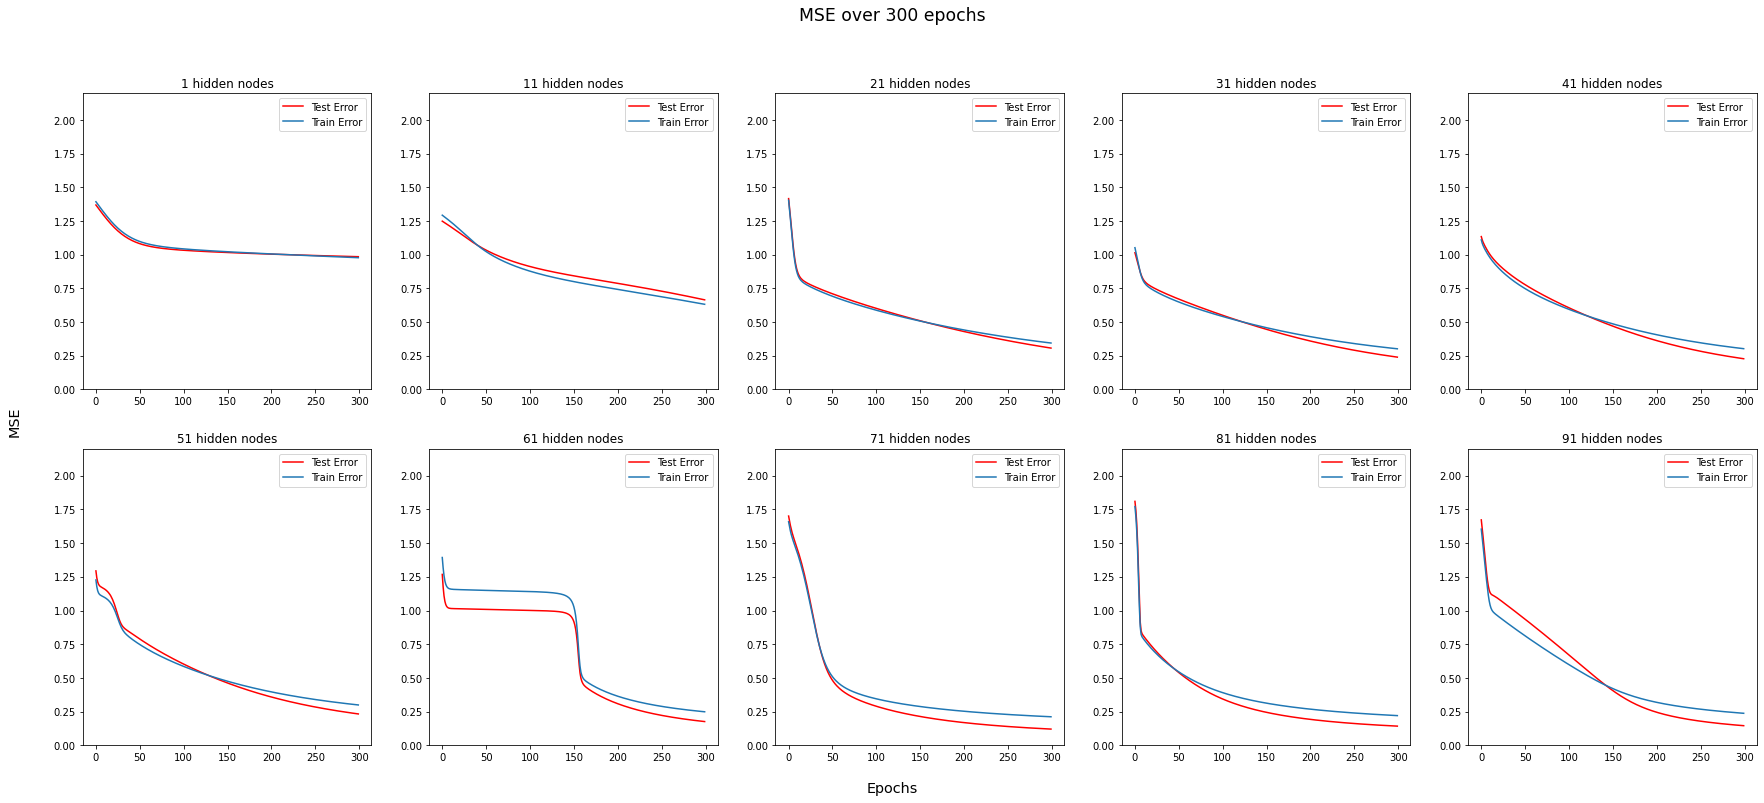

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(30, 12))
ax = ax.ravel()
for i in range(1, 11):
    ax[i - 1].plot(mse_test[i-1], c = "red", label = "Test Error")
    ax[i - 1].plot(mse_train[i-1], label = "Train Error")
    ax[i - 1].set_title(str(hidden_nodes[i-1])+ " hidden nodes")
    ax[i-1].set_ylim(0, 2.2)
    ax[i-1].legend()
fig.text(0.09, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.5, 0.07,'Epochs', ha="center", size = "x-large")
fig.suptitle("MSE over 300 epochs", size = "xx-large")

For 1 hidden neuron we can see the test and training error staying costant over the 300 epochs, however both these errors are high, meaning that the model is not complex enough to learn the data (not even the training data).

For most of the other number of hidden neurons, we observe that both the training and test errors decrease with the number of epochs, meaning that the model has not reached the point of overfitting, indeed both error are low.

The difference between training and test error shown here is mainly due to randomization.

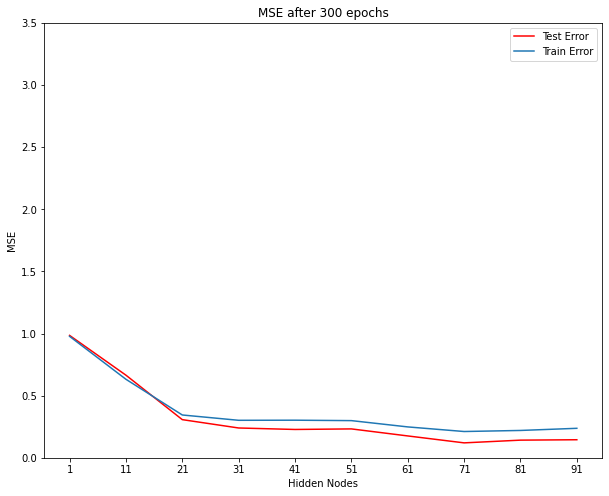

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(mse_test[:,299], c = "red", label = "Test Error")
plt.xlabel("Hidden Nodes")
plt.plot(mse_train[:, 299], label = "Train Error")
plt.ylabel("MSE")
plt.xticks(np.arange(10), hidden_nodes)
plt.title("MSE after 300 epochs")
plt.ylim(0,3.5)
plt.legend()
plt.show();

We can't observe a clear pattern as the number of hidden nodes increases. The small size of the data sets make the learning very subsceptible to randomization.

In [ ]:
np.random.seed(13)
nn = NeuralNetwork(X = train_data25, y = train_targets25, eta=0.01, alpha = 0.1,  n_hidden_neurons=41)
nn.train(300)

y_predict_test = nn.predict(test_data25)
t_test = np.array([-1 if i < 0 else 1 for i in y_predict_test.T])

/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


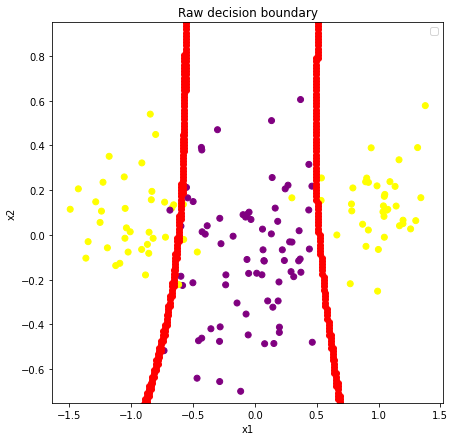

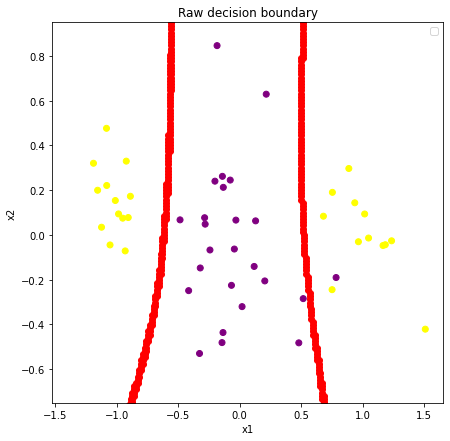

In [ ]:
printBinaryData(train_data25, train_targets25, "Raw decision boundary")
printDecisionBoundary(nn, boundaryWidth=0.07, resolution=200)

printBinaryData(test_data25, test_targets25, "Raw decision boundary")
printDecisionBoundary(nn, boundaryWidth=0.07, resolution=200)

Test: random 50% from class A

In [ ]:
epochs = 300

hidden_nodes = np.arange(1,100,10)

mse_train = np.zeros((len(hidden_nodes), epochs))
accuracy_train = np.zeros((len(hidden_nodes), epochs))

mse_test = np.zeros((len(hidden_nodes), epochs))
accuracy_test = np.zeros((len(hidden_nodes), epochs))

np.random.seed(12)
for i,h in enumerate(hidden_nodes):
    nn = NeuralNetwork(X = train_data50, y = train_targets50, eta=0.001, alpha = 0.25,  n_hidden_neurons=h)
    for e in range(epochs):
        nn.train(1)

        y_predict_test = nn.predict(test_data50)
        t_test = np.array([-1 if i < 0 else 1 for i in y_predict_test.T])

        y_predict_train = nn.predict(train_data50)
        t_train = np.array([-1 if i < 0 else 1 for i in y_predict_train.T])

        mse_test[i][e] = MSE(test_targets50, y_predict_test)
        accuracy_test[i][e] = accuracy_score(test_targets50, t_test)

        mse_train[i][e] = MSE(train_targets50, y_predict_train)
        accuracy_train[i][e] = accuracy_score(train_targets50, t_train)

Text(0.5, 0.98, 'MSE over 300 epochs')

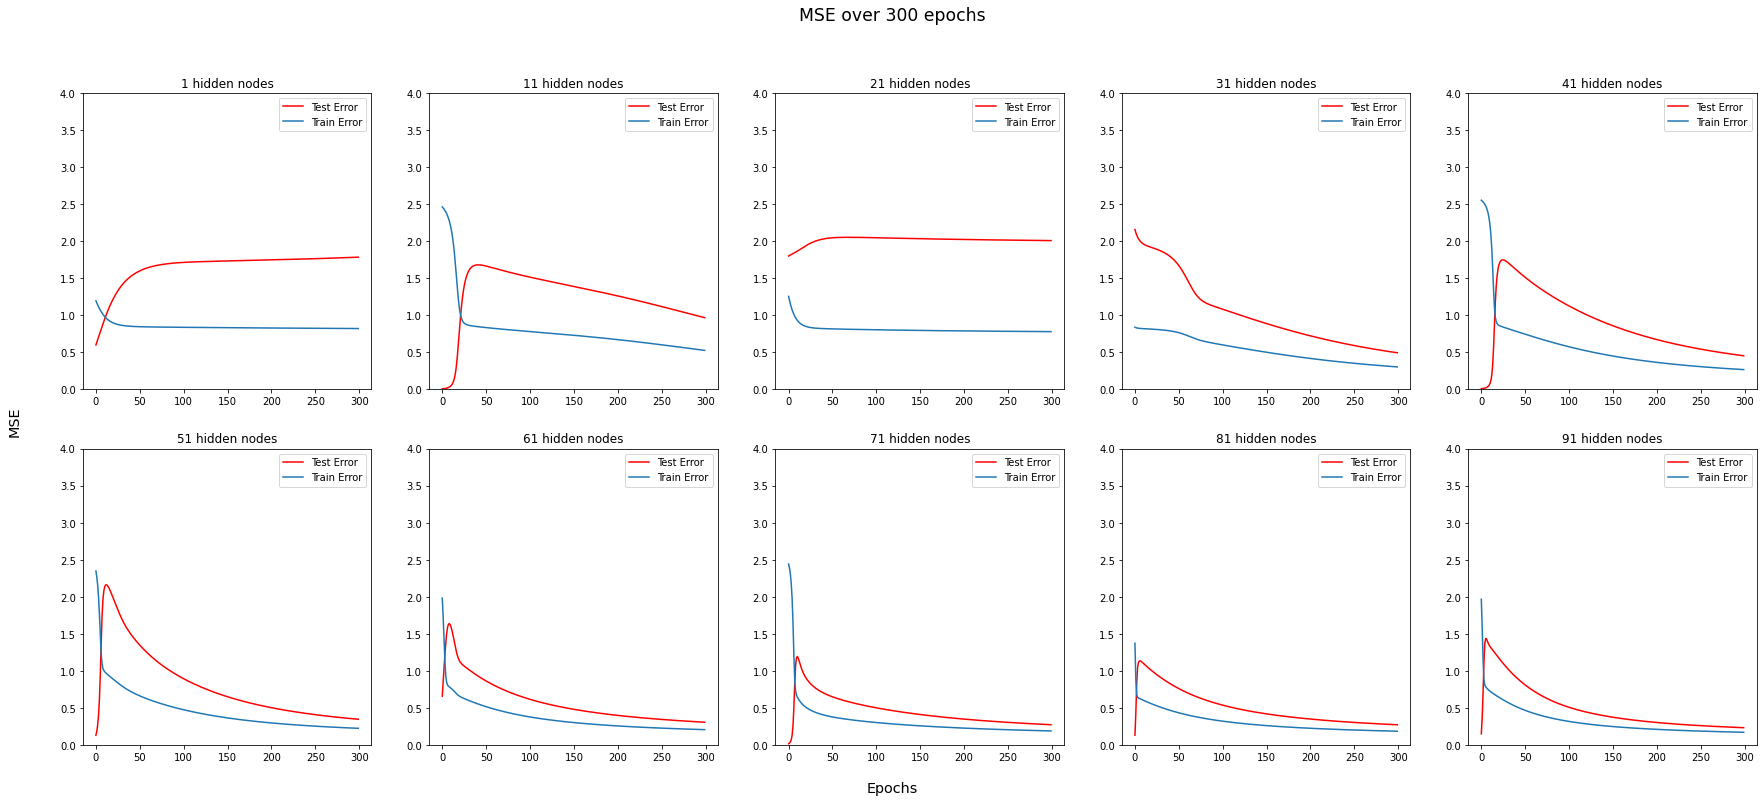

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(30, 12))
ax = ax.ravel()
for i in range(1, 11):
    ax[i - 1].plot(mse_test[i-1], c = "red", label = "Test Error")
    ax[i - 1].plot(mse_train[i-1], label = "Train Error")
    ax[i - 1].set_title(str(hidden_nodes[i-1])+ " hidden nodes")
    ax[i-1].set_ylim(0, 4)
    ax[i-1].legend()
fig.text(0.09, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.5, 0.07,'Epochs', ha="center", size = "x-large")
fig.suptitle("MSE over 300 epochs", size = "xx-large")

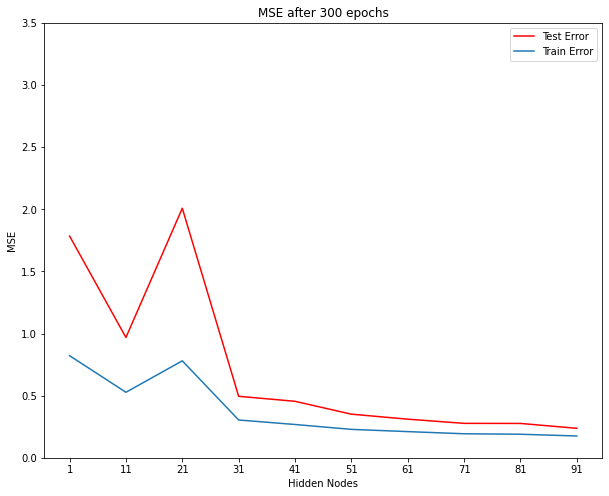

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(mse_test[:,299], c = "red", label = "Test Error")
plt.xlabel("Hidden Nodes")
plt.plot(mse_train[:, 299], label = "Train Error")
plt.ylabel("MSE")
plt.xticks(np.arange(10), hidden_nodes)
plt.title("MSE after 300 epochs")
plt.ylim(0,3.5)
plt.legend()
plt.show();

In [ ]:
np.random.seed(12)
nn = NeuralNetwork(X = train_data50, y = train_targets50, eta=0.001, alpha = 0.25,  n_hidden_neurons=31)
nn.train(300)

y_predict_test = nn.predict(test_data50)
t_test = np.array([-1 if i < 0 else 1 for i in y_predict_test.T])

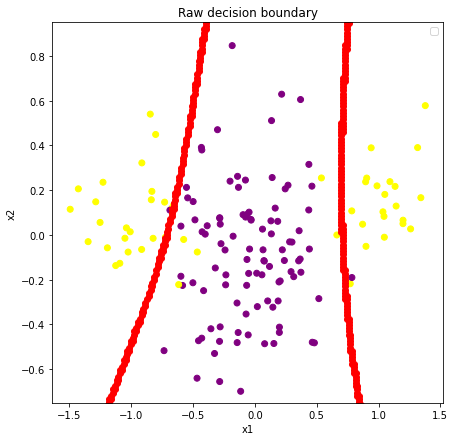

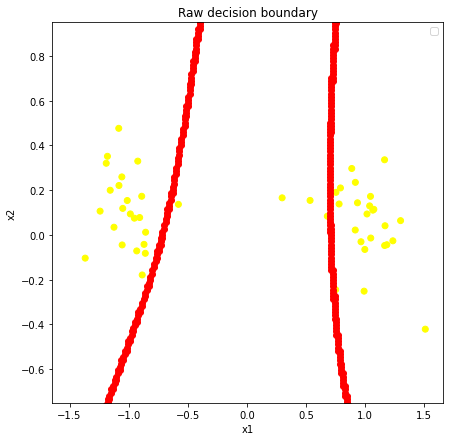

In [ ]:
printBinaryData(train_data50, train_targets50, "Raw decision boundary")
printDecisionBoundary(nn, boundaryWidth=0.02, resolution=200)

printBinaryData(test_data50, test_targets50, "Raw decision boundary")
printDecisionBoundary(nn, boundaryWidth=0.02, resolution=200)

Test: random 20% from a subset of classA for which classA(1,:) < 0 and 80% from
a subset of classA for which classA(1,:) > 0

In [ ]:
epochs = 300

hidden_nodes = np.arange(1,100,10)

mse_train = np.zeros((len(hidden_nodes), epochs))
accuracy_train = np.zeros((len(hidden_nodes), epochs))

mse_test = np.zeros((len(hidden_nodes), epochs))
accuracy_test = np.zeros((len(hidden_nodes), epochs))

np.random.seed(12)
for i,h in enumerate(hidden_nodes):
    nn = NeuralNetwork(X = train_data_s, y = train_targets_s, eta=0.001, alpha = 0.25,  n_hidden_neurons=h)
    for e in range(epochs):
        nn.train(1)

        y_predict_test = nn.predict(test_data_s)
        t_test = np.array([-1 if i < 0 else 1 for i in y_predict_test.T])

        y_predict_train = nn.predict(train_data_s)
        t_train = np.array([-1 if i < 0 else 1 for i in y_predict_train.T])

        mse_test[i][e] = MSE(test_targets_s, y_predict_test)
        accuracy_test[i][e] = accuracy_score(test_targets_s, t_test)

        mse_train[i][e] = MSE(train_targets_s, y_predict_train)
        accuracy_train[i][e] = accuracy_score(train_targets_s, t_train)

Text(0.5, 0.98, 'MSE over 300 epochs')

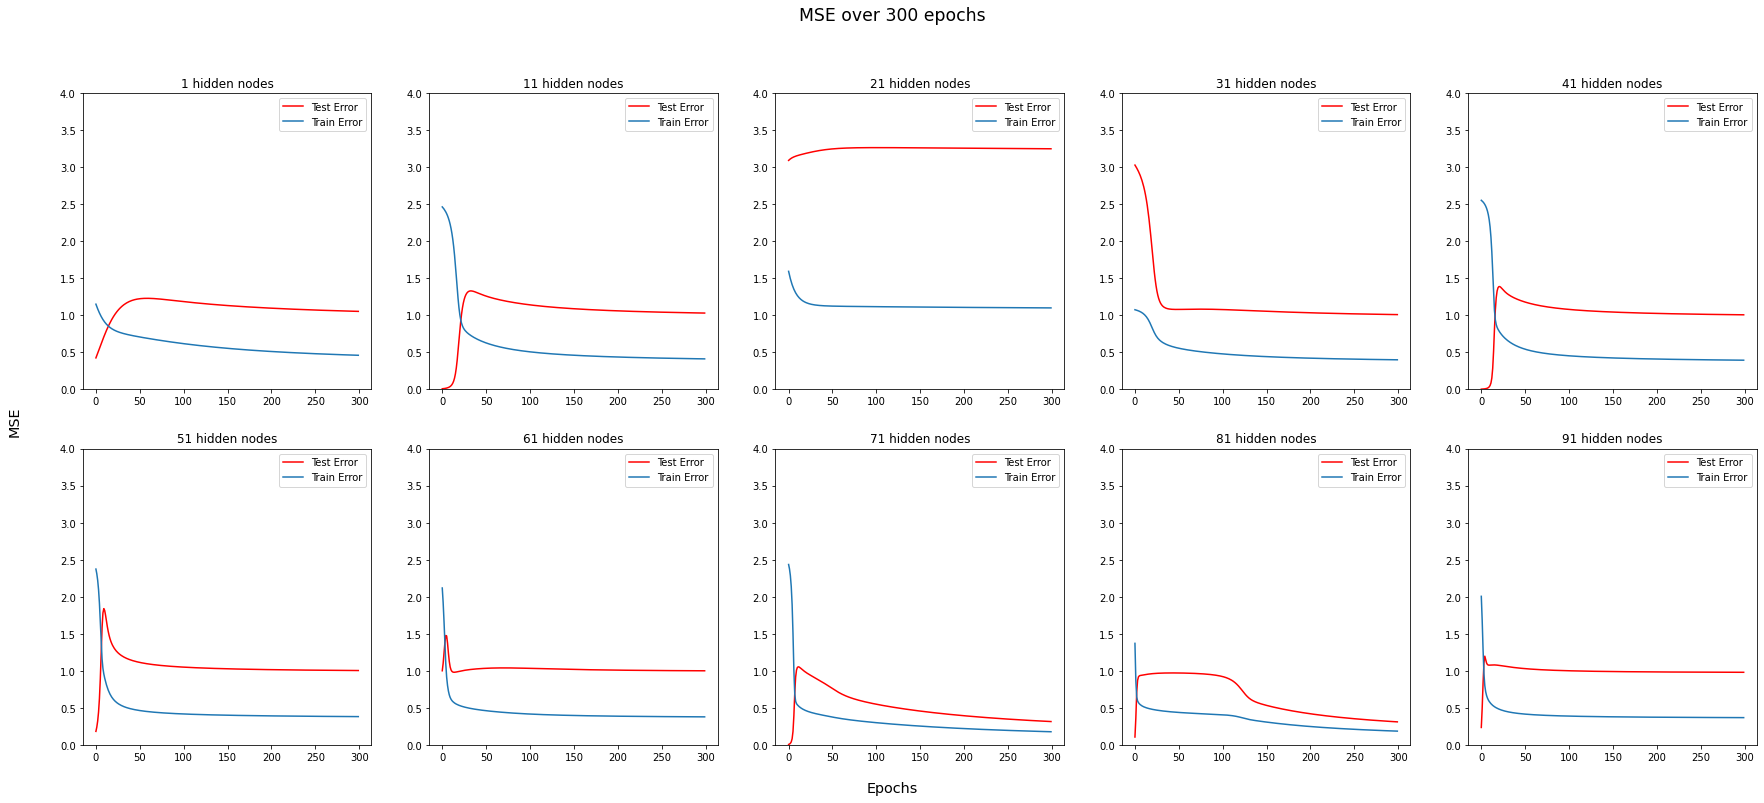

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(30, 12))
ax = ax.ravel()
for i in range(1, 11):
    ax[i - 1].plot(mse_test[i-1], c = "red", label = "Test Error")
    ax[i - 1].plot(mse_train[i-1], label = "Train Error")
    ax[i - 1].set_title(str(hidden_nodes[i-1])+ " hidden nodes")
    ax[i-1].set_ylim(0, 4)
    ax[i-1].legend()
fig.text(0.09, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.5, 0.07,'Epochs', ha="center", size = "x-large")
fig.suptitle("MSE over 300 epochs", size = "xx-large")

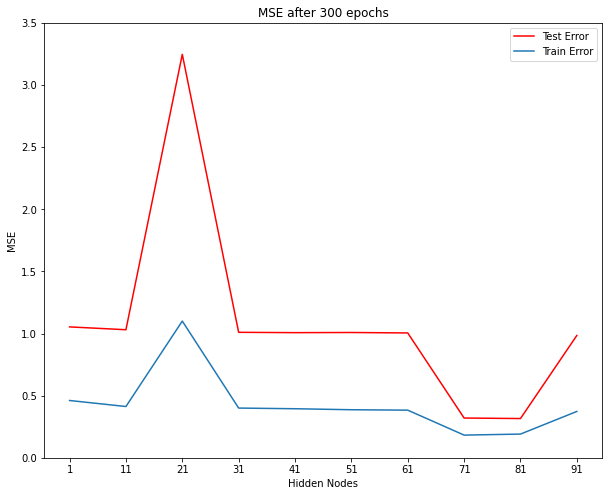

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(mse_test[:,299], c = "red", label = "Test Error")
plt.xlabel("Hidden Nodes")
plt.plot(mse_train[:, 299], label = "Train Error")
plt.ylabel("MSE")
plt.xticks(np.arange(10), hidden_nodes)
plt.title("MSE after 300 epochs")
plt.ylim(0,3.5)
plt.legend()
plt.show();

In [ ]:
np.random.seed(12)
nn = NeuralNetwork(X = train_data_s, y = train_targets_s, eta=0.001, alpha = 0.25,  n_hidden_neurons=41)
nn.train(300)

y_predict_test = nn.predict(test_data_s)
t_test = np.array([-1 if i < 0 else 1 for i in y_predict_test.T])

/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


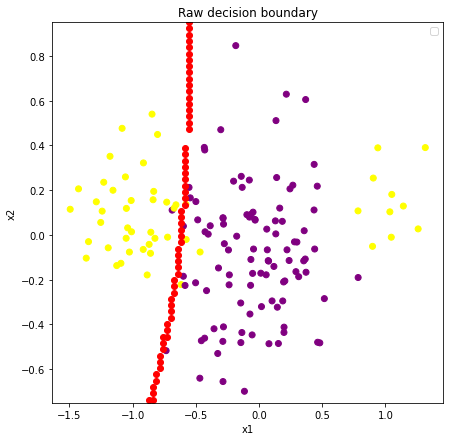

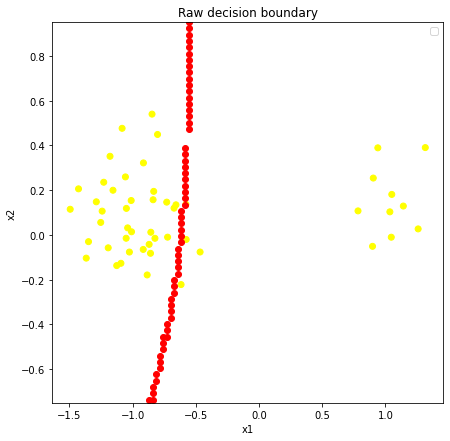

In [ ]:
printBinaryData(train_data_s, train_targets_s, "Raw decision boundary")
printDecisionBoundary(nn, boundaryWidth=0.05)

printBinaryData(test_data_s, test_targets_s, "Raw decision boundary")
printDecisionBoundary(nn, boundaryWidth=0.05)

##Function approximation

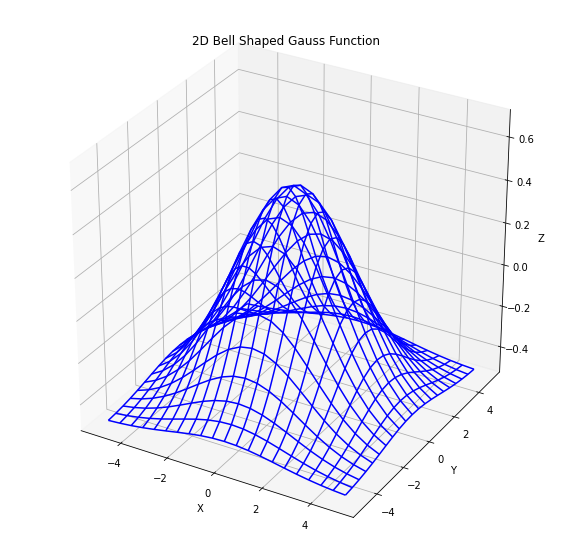

In [ ]:
#Create dataset
x=np.linspace(-5,5,21).reshape((21,1))
y=np.linspace(-5,5,21).reshape((21,1))
z=np.exp(-x*x*0.1) @ (np.exp(-y*y*0.1).T) -0.5
X,Y = np.meshgrid(x,y)
N=z.size

targets=z.copy().reshape((1, N))
points=np.concatenate((X.reshape((1,N)), Y.reshape((1,N))), axis=0)

plot3D(X,Y,z, "2D Bell Shaped Gauss Function", zlim=(-0.5, 0.7))

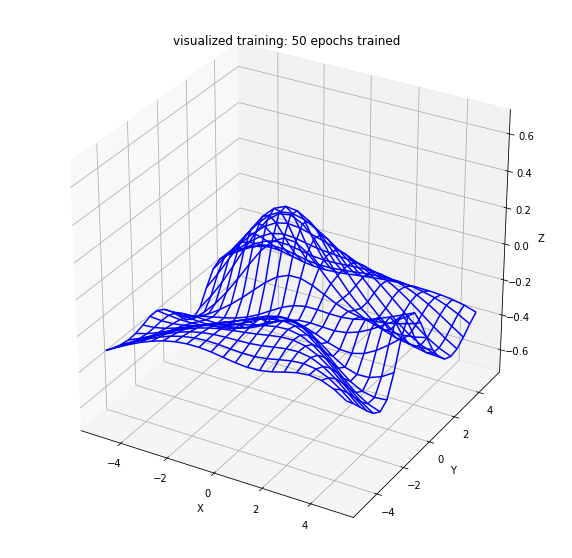

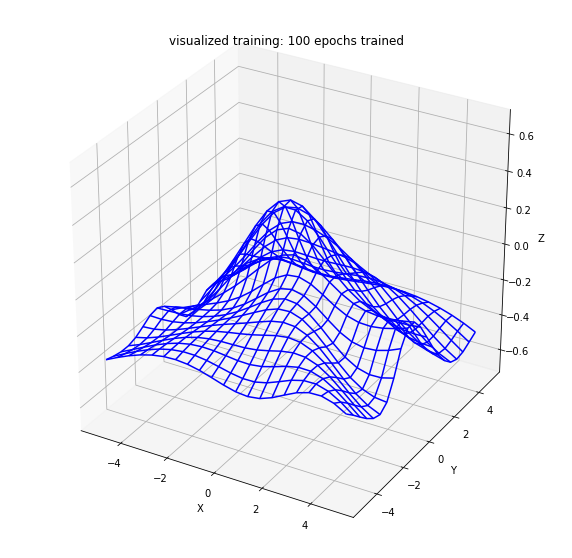

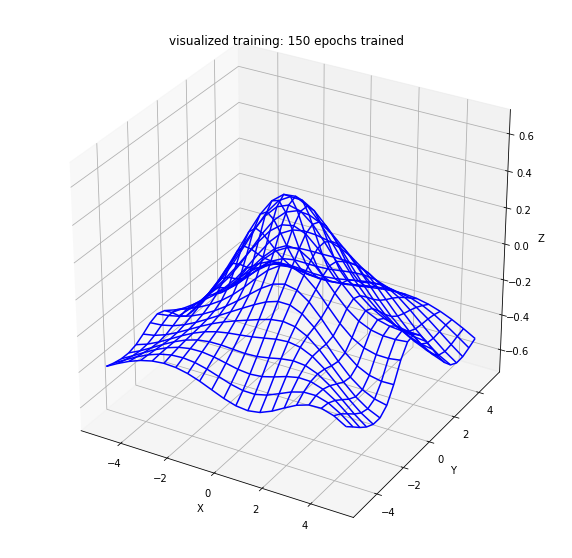

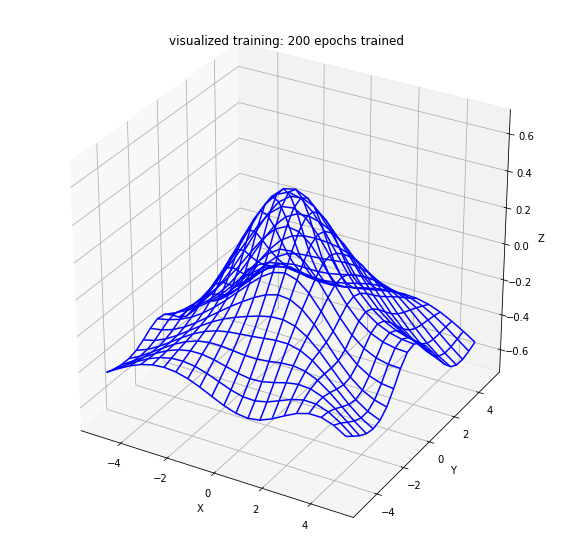

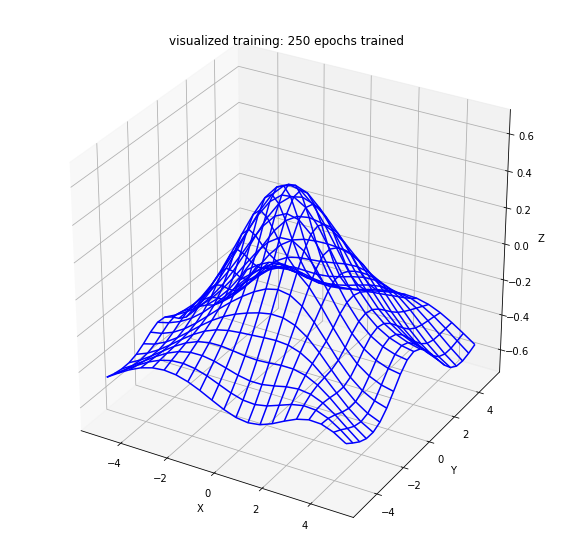

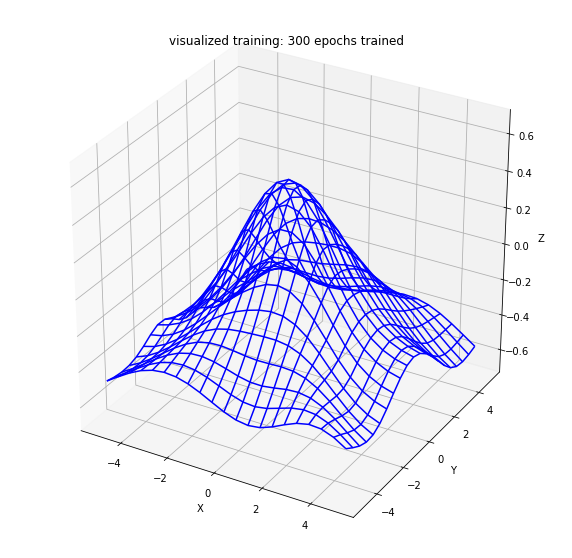

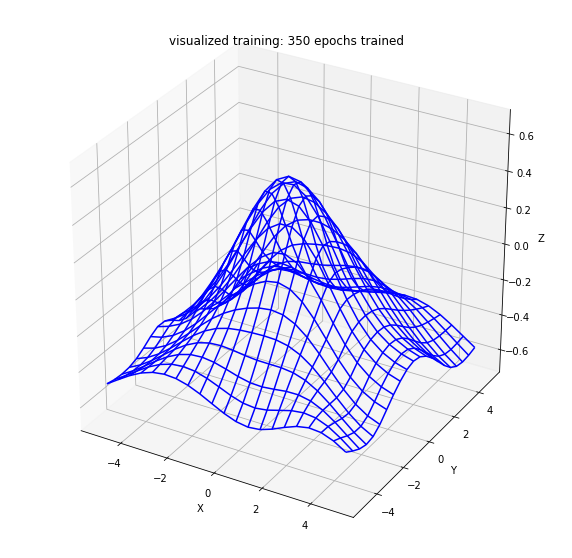

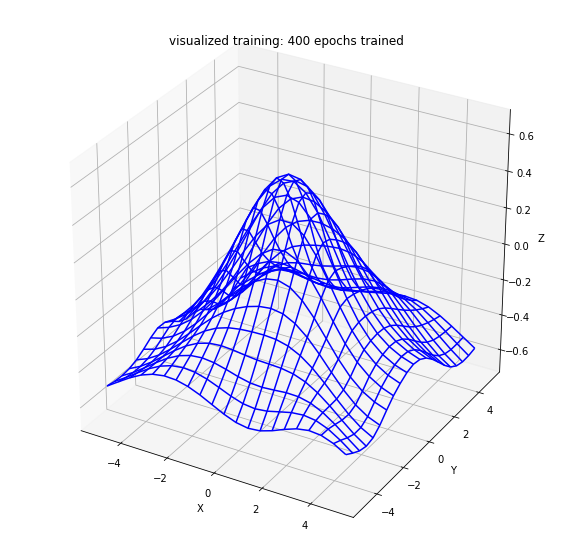

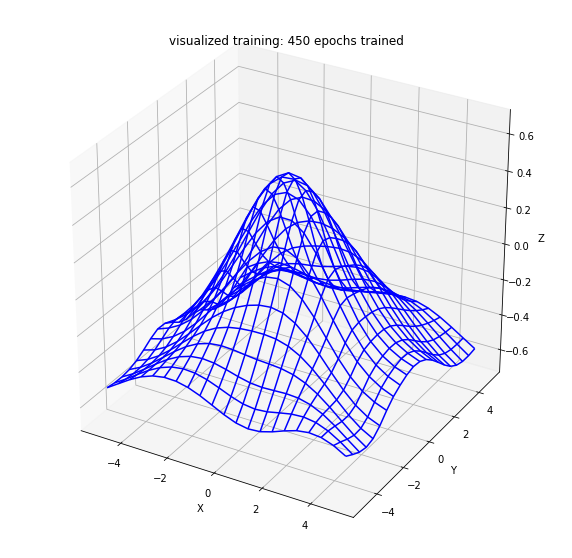

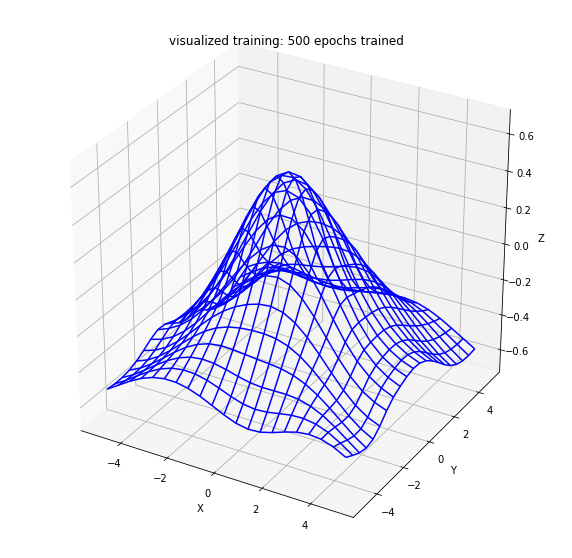

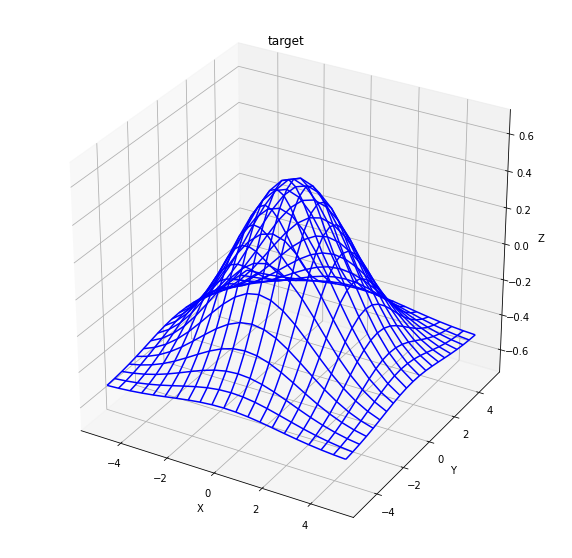

In [ ]:

def visualize3DTraining(epochs, nn, epochsPerFrame=25):
  trainedEpochs=0
  points=nn.X_bias[:nn.n_features-1,:]
  while trainedEpochs<epochs:
    if trainedEpochs+epochsPerFrame<=epochs:
      nn.train(epochsPerFrame)
      trainedEpochs+=epochsPerFrame
    else:
      nn.train(epochs-trainedEpochs)
      trainedEpochs+=epochs-trainedEpochs

    print3DFromNetwork(points, nn, "visualized training: "+str(trainedEpochs)+" epochs trained")

#Visualizes training of network
np.random.seed(13)
nn=NeuralNetwork(points, targets, 15, 0.001, 0.1)
visualize3DTraining(500, nn, 50)

plot3D(X,Y,z, "target")


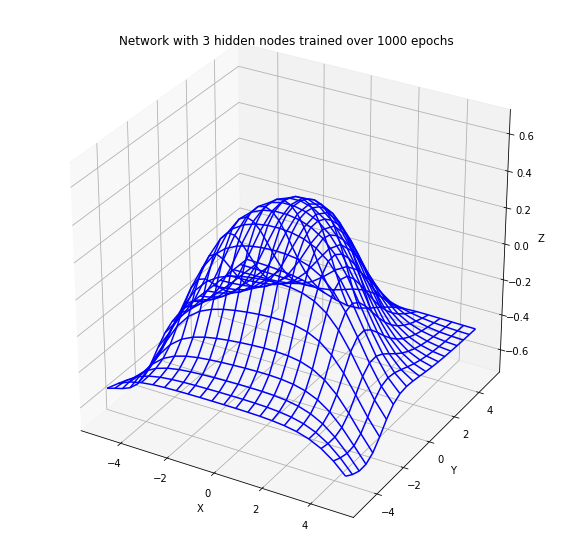

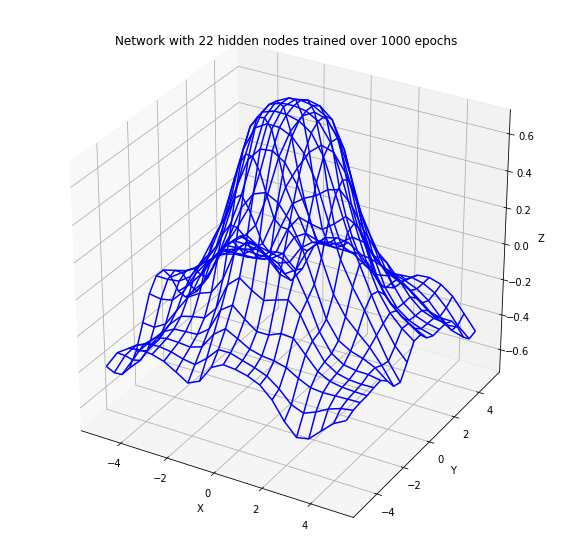

In [ ]:
#Shows how very few (3) nodes fail to find a good enough approximation due to not being expressive enough
np.random.seed(13)
nn=NeuralNetwork(points, targets, 3, 0.01, 0.1)
nn.train(1000)
print3DFromNetwork(points, nn, "Network with 3 hidden nodes trained over 1000 epochs")

#Shows how very many (80) nodes fail to find a good enough approximation due to having trouble training so many nodes into a good minima
np.random.seed(13)
nn=NeuralNetwork(points, targets, 22, 0.01, 0.1)
nn.train(1000)
print3DFromNetwork(points, nn, "Network with 22 hidden nodes trained over 1000 epochs")

In [ ]:

#Finding the "best" model by choosing the best performing one (in terms of MSE) over 20 random initializations and 1 to 25 hidden nodes (all trained over 200 epochs).

nodeRange=np.linspace(1,25,10).astype(int)

bestMSEvec=np.zeros(10)

bestMSE=np.inf
bestSeed=0
bestHiddenNodes=0

#Itterating over all options and saving the best ones
for t,hiddenNodes in enumerate(nodeRange):
  bestMSENode=np.inf
  for i in range(20):
    np.random.seed(i*10)
    nn=NeuralNetwork(points, targets, hiddenNodes, 0.01, 0.1)
    nn.train(200)
    error=MSE(targets, nn.predict(points))

    if error<bestMSENode:
      bestMSENode=error
      if error<bestMSE:
        bestMSE=error
        bestSeed=i*10
        bestHiddenNodes=hiddenNodes
  bestMSEvec[t]=bestMSENode


Seed: 180 	Hidden nodes: 6


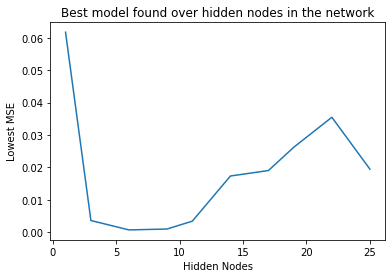

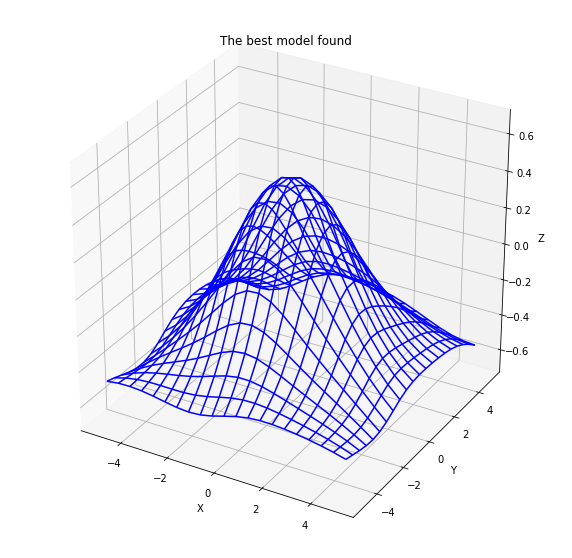

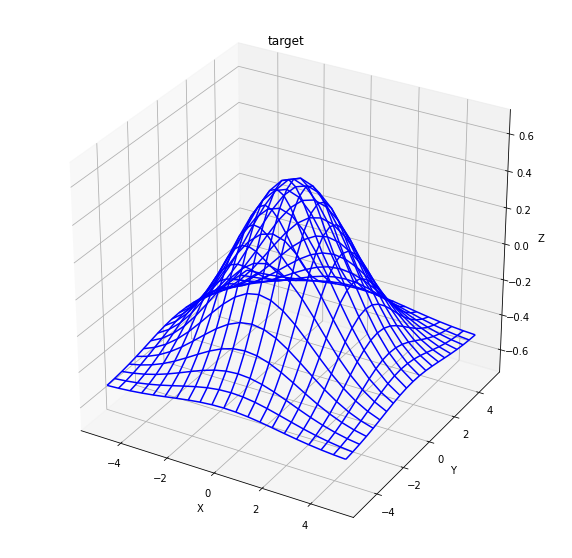

In [ ]:
#Plots best model found for over hidden nodes
ax=plt.subplot()
ax.set_title("Best model found over hidden nodes in the network")
ax.set_ylabel("Lowest MSE")
ax.set_xlabel("Hidden Nodes")
ax.plot(nodeRange,bestMSEvec)

#Plots the best model found
np.random.seed(bestSeed)
nn=NeuralNetwork(points, targets, bestHiddenNodes, 0.01, 0.1)
nn.train(200)
print("Seed:",bestSeed,"\tHidden nodes:",bestHiddenNodes)
print3DFromNetwork(points, nn, "The best model found")
plot3D(X,Y,z, "target")

##Part II

In [ ]:
#import and use MLP framework

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import optimizers
from keras.callbacks import EarlyStopping

In [ ]:
#data generation function

def Next(l):
    x_new=0.9*l[-1]+0.2*l[-26]/(1+l[-26]**10)
    return x_new


def GenerateData(n):
    data=[0 for k in range(25)]
    data.append(1.5)
    for i in range(n):
        data.append(Next(data))
    return(data[25:])

def PrintData(data):
    plt.figure(figsize=(7,5))
    x=[k for k in range(len(data))]
    plt.plot(x,data)
    plt.plot(x,data,color='blue')
    plt.xlabel("Time")
    plt.title("Generated Time Series")
    plt.show()

def GenerateInputsOutputs(data):
    inputs=[]
    outputs=[]
    for k in range(len(data)-25):
        inputs.append([data[k],data[k+5],data[k+10],data[k+15],data[k+20]])
        outputs.append(data[k+25])
    return inputs,outputs

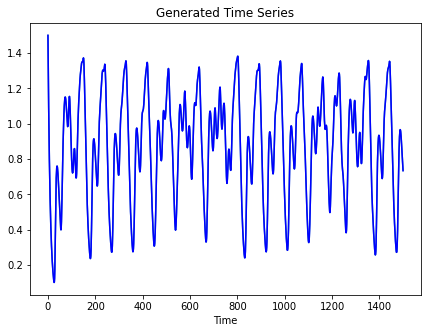

In [ ]:
PrintData(GenerateData(1500))

In [ ]:
#generating the data and splitting

data = GenerateData(1500)[276:]
input,output=GenerateInputsOutputs(data)

train_input=input[:800]
validation_input=input[800:1000]
test_input=input[1000:]

train_output=output[:800]
validation_output=output[800:1000]
test_output=output[1000:]

In [ ]:
#model using the sklearn library
def MSE(targets, values):
  return np.mean((targets-values)**2)

nh1=[3,4,5]
nh2=[2,4,6]
for k in nh1:
    for j in nh2:
        hidden_layers=(k,j)
        model=MLPRegressor(hidden_layer_sizes=hidden_layers, activation='logistic', alpha=0.0001, solver='sgd', learning_rate='adaptive', learning_rate_init=0.001,  max_iter=200, early_stopping=True, validation_fraction=0.1).fit(train_input,train_output)
        print("Mean Square Error:", MSE(model.predict(validation_input),validation_output), "Hidden layers:", hidden_layers)

Mean Square Error: 0.05825843112458596 Hidden layers: (3, 2)
Mean Square Error: 0.059740947787714924 Hidden layers: (3, 4)
Mean Square Error: 0.0590957341917321 Hidden layers: (3, 6)
Mean Square Error: 0.06004784543138106 Hidden layers: (4, 2)
Mean Square Error: 0.05945069035732068 Hidden layers: (4, 4)
Mean Square Error: 0.058542156649976175 Hidden layers: (4, 6)
Mean Square Error: 0.059162369427761895 Hidden layers: (5, 2)
Mean Square Error: 0.059499904043506156 Hidden layers: (5, 4)
Mean Square Error: 0.059200035037116655 Hidden layers: (5, 6)


In [ ]:
#model using the tensorflow library

#Model
model = Sequential()
model.add(Dense(3, input_shape=(5,), activation='sigmoid'))
model.add(Dense(4, activation='sigmoid'))
model.add(Dense(1, activation='linear',))

#Optimizer
opt = optimizers.SGD(learning_rate=0.15,decay=1e-06)
opt2 = optimizers.Adagrad(learning_rate=0.15, epsilon=1e-06,)

#Compiling
model.compile(loss='mean_squared_error',
              optimizer=opt)

model.summary()


Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_207 (Dense)           (None, 3)                 18        
                                                                 
 dense_208 (Dense)           (None, 4)                 16        
                                                                 
 dense_209 (Dense)           (None, 1)                 5         
                                                                 
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training
epochs = 200
batch_size = 20
callback = EarlyStopping(monitor='val_loss',min_delta=0, patience=3)

history = model.fit(train_input, train_output,
                    batch_size=batch_size,
                    epochs=epochs, callbacks=[callback],
                    validation_data=(validation_input, validation_output))

Epoch 1/200
40/40 [==============================] - 1s 6ms/step - loss: 0.1011 - val_loss: 0.0503
Epoch 2/200
40/40 [==============================] - 0s 5ms/step - loss: 0.0722 - val_loss: 0.0474
Epoch 3/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0681 - val_loss: 0.0448
Epoch 4/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0646 - val_loss: 0.0428
Epoch 5/200
40/40 [==============================] - 0s 5ms/step - loss: 0.0605 - val_loss: 0.0407
Epoch 6/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0572 - val_loss: 0.0376
Epoch 7/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0532 - val_loss: 0.0353
Epoch 8/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0496 - val_loss: 0.0359
Epoch 9/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0464 - val_loss: 0.0317
Epoch 10/200
40/40 [==============================] - 0s 8ms/step - loss: 0.0449 - val_loss: 0.0354
Epoch 11/

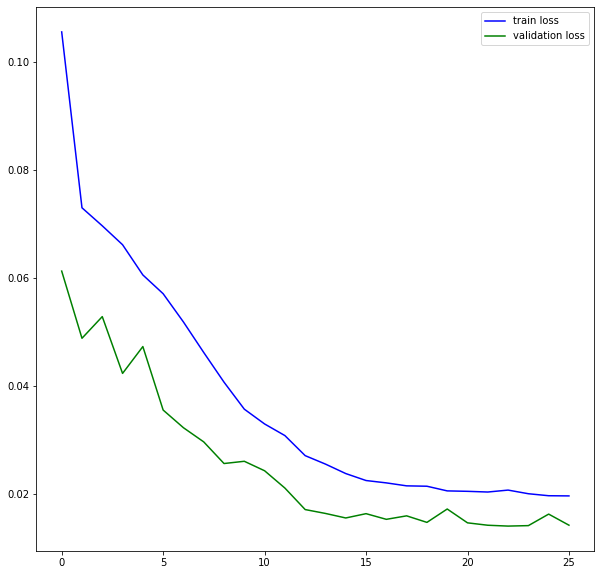

In [ ]:
fig = plt.figure(figsize=(10, 10))

plt.plot(history.history['loss'], color='blue', label='train loss')
plt.plot(history.history['val_loss'], color='green', label='validation loss')
plt.legend()
plt.show()

7/7 [==============================] - 0s 2ms/step


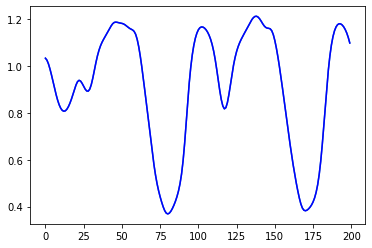

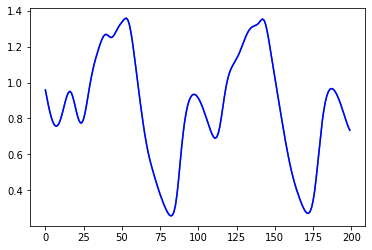

In [ ]:
PrintData(model.predict(test_input))
PrintData(test_output)

In [ ]:
MSE(model.predict(test_input).reshape(200,),test_output)

In [ ]:
plt.plot(model.predict(test_input).reshape(200,), color='blue', label='predicted values')
plt.plot(test_output, color='green', label='correct values')
plt.legend()
plt.show()

Epoch 1/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1113 - val_loss: 0.0570
Epoch 2/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0826 - val_loss: 0.0559
Epoch 3/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0802 - val_loss: 0.0581
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0825 - val_loss: 0.0553
Epoch 5/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0804 - val_loss: 0.0594
Epoch 6/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0799 - val_loss: 0.0546
Epoch 7/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0797 - val_loss: 0.0544
Epoch 8/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0783 - val_loss: 0.0529
Epoch 9/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0772 - val_loss: 0.0538
Epoch 10/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0777 - val_loss: 0.0573
Epoch 11/

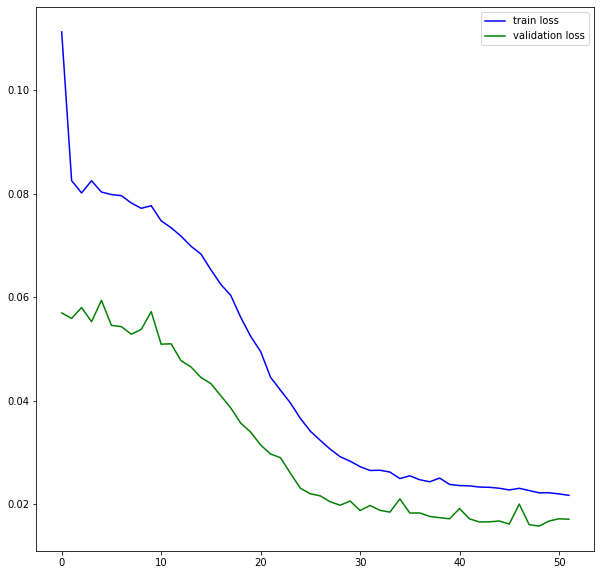

Epoch 1/200
40/40 [==============================] - 0s 5ms/step - loss: 0.0859 - val_loss: 0.0525
Epoch 2/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0759 - val_loss: 0.0498
Epoch 3/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0718 - val_loss: 0.0477
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0687 - val_loss: 0.0465
Epoch 5/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0661 - val_loss: 0.0451
Epoch 6/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0623 - val_loss: 0.0405
Epoch 7/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0591 - val_loss: 0.0379
Epoch 8/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0552 - val_loss: 0.0351
Epoch 9/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0323
Epoch 10/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0358
Epoch 11/

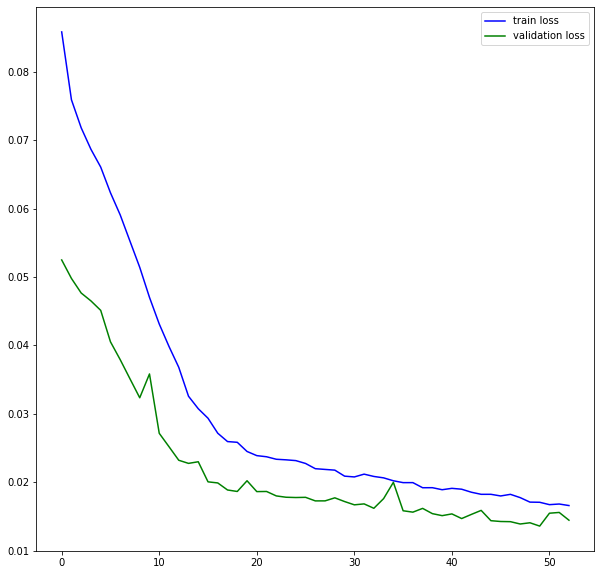

Epoch 1/200
40/40 [==============================] - 0s 5ms/step - loss: 0.0886 - val_loss: 0.0642
Epoch 2/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0842 - val_loss: 0.0548
Epoch 3/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0527
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0739 - val_loss: 0.0563
Epoch 5/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0683 - val_loss: 0.0440
Epoch 6/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0629 - val_loss: 0.0394
Epoch 7/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0573 - val_loss: 0.0345
Epoch 8/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0300
Epoch 9/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0435 - val_loss: 0.0261
Epoch 10/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0378 - val_loss: 0.0301
Epoch 11/

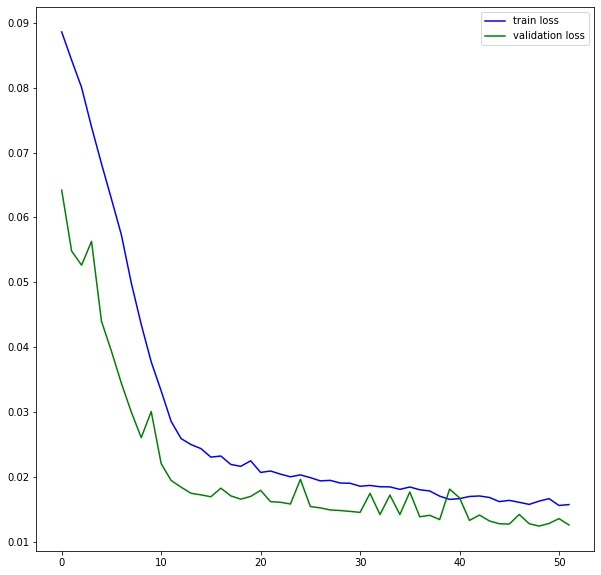

Epoch 1/200
40/40 [==============================] - 0s 5ms/step - loss: 0.0934 - val_loss: 0.0647
Epoch 2/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0906 - val_loss: 0.0636
Epoch 3/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0897 - val_loss: 0.0649
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0876 - val_loss: 0.0613
Epoch 5/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0874 - val_loss: 0.0610
Epoch 6/200
40/40 [==============================] - 0s 2ms/step - loss: 0.0865 - val_loss: 0.0601
Epoch 7/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0856 - val_loss: 0.0630
Epoch 8/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0852 - val_loss: 0.0595
Epoch 9/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0843 - val_loss: 0.0596
Epoch 10/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0606
Epoch 11/

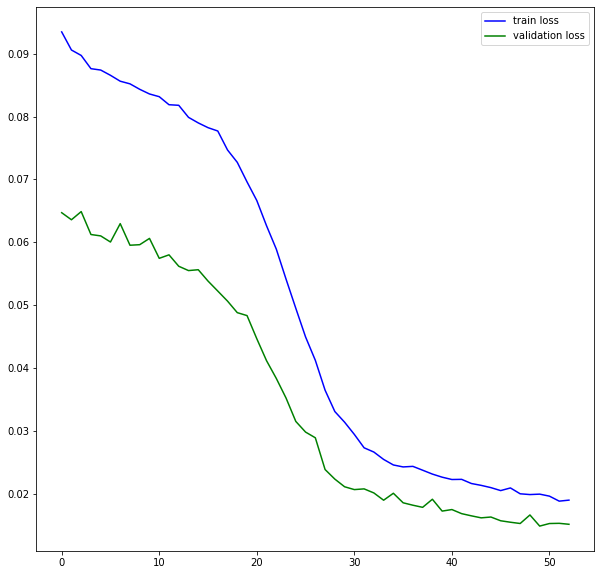

Epoch 1/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1202 - val_loss: 0.0565
Epoch 2/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0792 - val_loss: 0.0530
Epoch 3/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0761 - val_loss: 0.0513
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0742 - val_loss: 0.0506
Epoch 5/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0699 - val_loss: 0.0464
Epoch 6/200
40/40 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0435
Epoch 7/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0624 - val_loss: 0.0402
Epoch 8/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0575 - val_loss: 0.0373
Epoch 9/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0334
Epoch 10/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0473 - val_loss: 0.0287
Epoch 11/

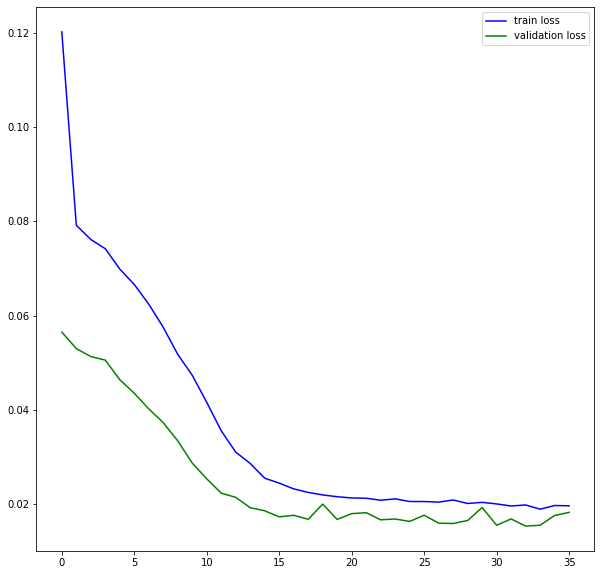

Epoch 1/200
40/40 [==============================] - 0s 6ms/step - loss: 0.1538 - val_loss: 0.0622
Epoch 2/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0897 - val_loss: 0.0617
Epoch 3/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0892 - val_loss: 0.0613
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0886 - val_loss: 0.0633
Epoch 5/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0870 - val_loss: 0.0591
Epoch 6/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0856 - val_loss: 0.0580
Epoch 7/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0863 - val_loss: 0.0579
Epoch 8/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0562
Epoch 9/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0808 - val_loss: 0.0554
Epoch 10/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0609
Epoch 11/

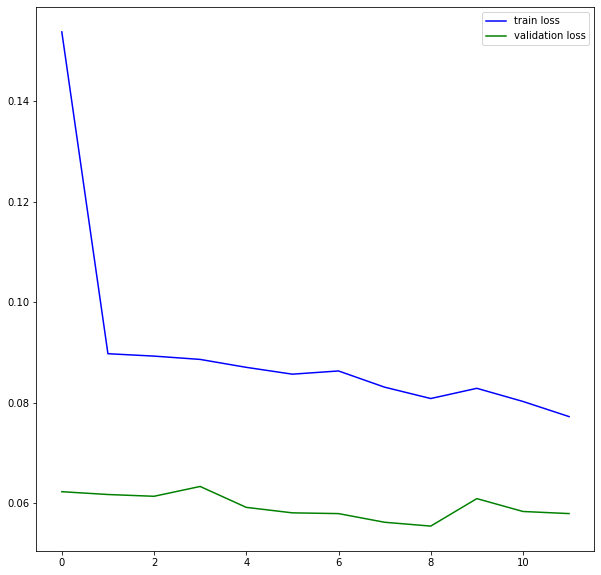

Epoch 1/200
40/40 [==============================] - 0s 6ms/step - loss: 0.1358 - val_loss: 0.0574
Epoch 2/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0825 - val_loss: 0.0580
Epoch 3/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0821 - val_loss: 0.0568
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0810 - val_loss: 0.0552
Epoch 5/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0790 - val_loss: 0.0543
Epoch 6/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0782 - val_loss: 0.0560
Epoch 7/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0754 - val_loss: 0.0510
Epoch 8/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0721 - val_loss: 0.0488
Epoch 9/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0699 - val_loss: 0.0465
Epoch 10/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0675 - val_loss: 0.0454
Epoch 11/

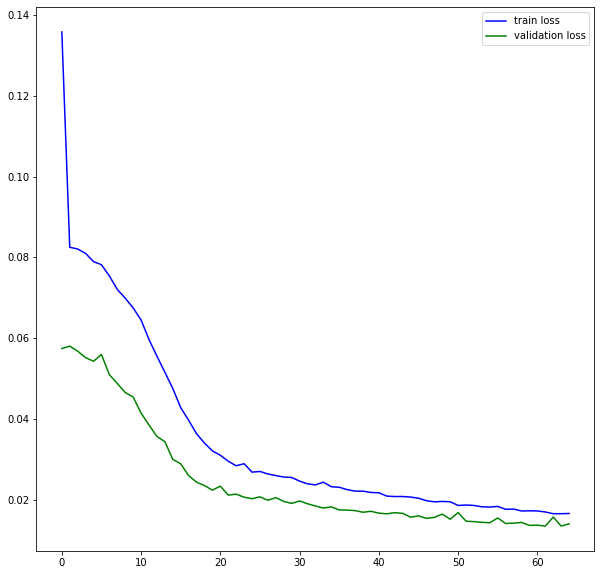

Epoch 1/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0858 - val_loss: 0.0644
Epoch 2/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0791 - val_loss: 0.0536
Epoch 3/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0790 - val_loss: 0.0548
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0760 - val_loss: 0.0528
Epoch 5/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0729 - val_loss: 0.0747
Epoch 6/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0705 - val_loss: 0.0519
Epoch 7/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0686 - val_loss: 0.0452
Epoch 8/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0648 - val_loss: 0.0429
Epoch 9/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0630 - val_loss: 0.0399
Epoch 10/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0586 - val_loss: 0.0370
Epoch 11/

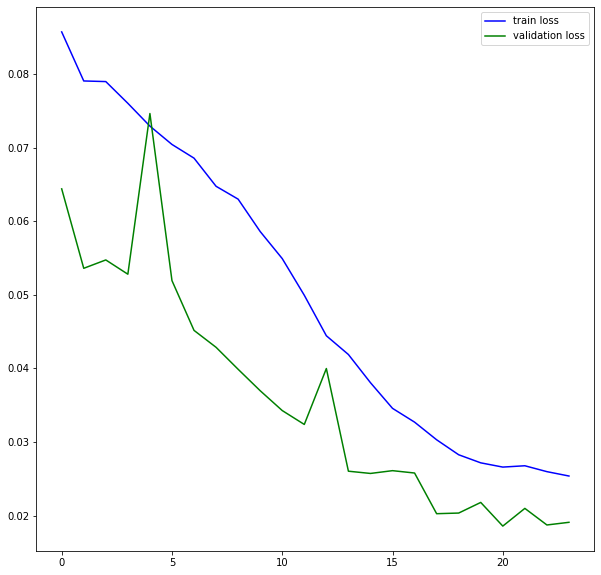

Epoch 1/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1883 - val_loss: 0.0613
Epoch 2/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0905 - val_loss: 0.0607
Epoch 3/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0876 - val_loss: 0.0671
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0881 - val_loss: 0.0585
Epoch 5/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0841 - val_loss: 0.0593
Epoch 6/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0855 - val_loss: 0.0646
Epoch 7/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0824 - val_loss: 0.0574
Epoch 8/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0838 - val_loss: 0.0577
Epoch 9/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0802 - val_loss: 0.0551
Epoch 10/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0795 - val_loss: 0.0536
Epoch 11/

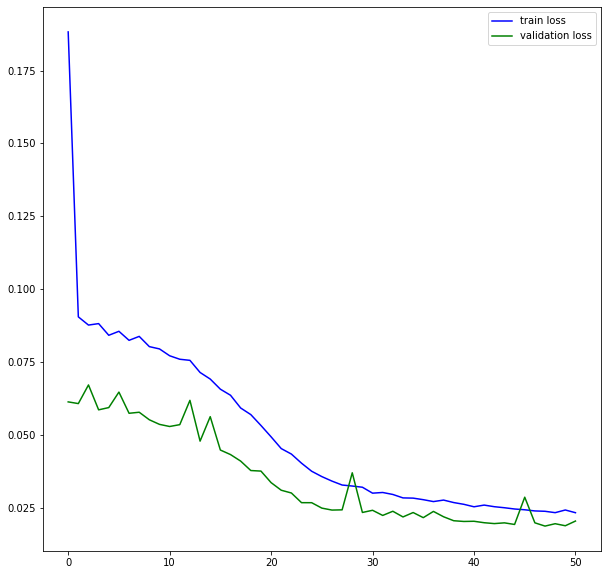

In [ ]:
#testing for different hidden layers
nh1=[3,4,5]
nh2=[2,4,6]
epochs = 200
batch_size = 20
for k in nh1:
    for j in nh2:
        hidden_layers=(k,j)
        model = Sequential()
        model.add(Dense(k, input_shape=(5,), activation='sigmoid'))
        model.add(Dense(j, activation='sigmoid'))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mean_squared_error',
              optimizer=opt)
        history = model.fit(train_input, train_output,
                    batch_size=batch_size,
                    epochs=epochs, callbacks=[callback],
                    validation_data=(validation_input, validation_output))
        fig = plt.figure(figsize=(10, 10))
        print(hidden_layers)
        plt.plot(history.history['loss'], color='blue', label='train loss')
        plt.plot(history.history['val_loss'], color='green', label='validation loss')
        plt.legend()
        plt.show()

In [ ]:
def evaluateModel(nh1,nh2):
    sum=0
    for k in range(5):
        hidden_layers=(nh1,nh2)
        model = Sequential()
        model.add(Dense(nh1, input_shape=(5,), activation='sigmoid'))
        model.add(Dense(nh2, activation='sigmoid'))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mean_squared_error',
              optimizer=opt)
        history = model.fit(train_input, train_output,
                    batch_size=batch_size,
                    epochs=epochs,callbacks=callback,
                    validation_data=(validation_input, validation_output))
        sum+=MSE(model.predict(validation_input).reshape(200,),validation_output)
    return(sum/5)

In [ ]:
for k in nh1:
    for j in nh2:
        print (k,j)
        print(evaluateModel(k,j))

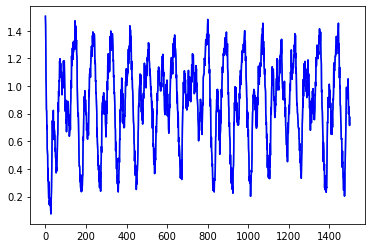

In [ ]:
noise = np.random.normal(0,0.09,1225)
data = GenerateData(1500)[276:] +noise
PrintData(data)

In [ ]:
input,output=GenerateInputsOutputs(data)

train_input=input[:800]
validation_input=input[800:1000]
test_input=input[1000:]

train_output=output[:800]
validation_output=output[800:1000]
test_output=output[1000:]

In [ ]:
#Model
epochs = 200
batch_size = 20
callback = EarlyStopping(monitor='val_loss',min_delta=0, patience=3)
model = Sequential()
model.add(Dense(4, input_shape=(5,), activation='sigmoid'))
model.add(Dense(6, activation='sigmoid'))
model.add(Dense(1, activation='linear',))

#Optimizer
opt = optimizers.SGD(learning_rate=0.1,decay=1e-05)
opt2 = optimizers.Adagrad(learning_rate=0.15, epsilon=1e-06,)


#Compiling
model.compile(loss='mean_squared_error',
              optimizer=opt)

model.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 3)                 18        
                                                                 
 dense_64 (Dense)            (None, 4)                 16        
                                                                 
 dense_65 (Dense)            (None, 1)                 5         
                                                                 
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
20/20 [==============================] - 1s 10ms/step - loss: 0.4104 - val_loss: 0.0342
Epoch 2/15
20/20 [==============================] - 0s 3ms/step - loss: 0.0214 - val_loss: 0.0351
Epoch 3/15
20/20 [==============================] - 0s 5ms/step - loss: 0.0213 - val_loss: 0.0344
Epoch 4/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0213 - val_loss: 0.0352
Epoch 5/15
20/20 [==============================] - 0s 5ms/step - loss: 0.0213 - val_loss: 0.0354
Epoch 6/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0213 - val_loss: 0.0351
Epoch 7/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0213 - val_loss: 0.0355
Epoch 8/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0213 - val_loss: 0.0346
Epoch 9/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0213 - val_loss: 0.0348
Epoch 10/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0212 - val_loss: 0.0349
Epoch 11/15
20/20 

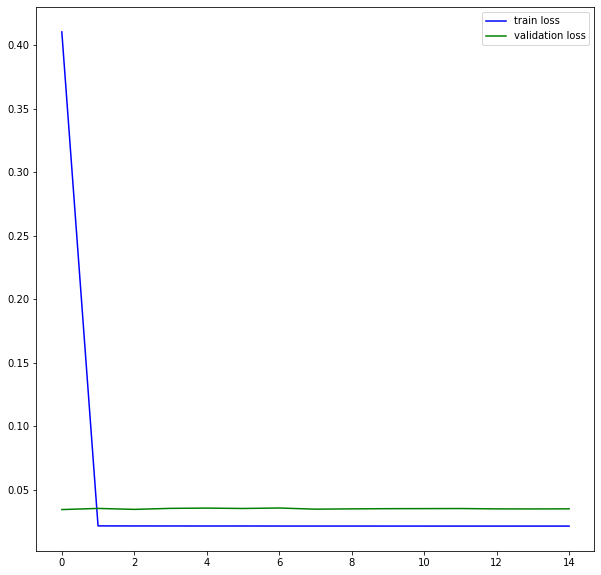

In [ ]:
history = model.fit(train_input, train_output,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(validation_input, validation_output))
fig = plt.figure(figsize=(10, 10))

plt.plot(history.history['loss'], color='blue', label='train loss')
plt.plot(history.history['val_loss'], color='green', label='validation loss')
plt.legend()
plt.show()

In [ ]:
#Training

history = model.fit(train_input, train_output,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(validation_input, validation_output))

In [ ]:
import numpy as np
np.var([0.4,0.3])

0.0025000000000000014